In [1]:
import os
import csv
import SimpleITK as sitk
import six
#from radiomics import featureextractor, getTestCase
#from radiomics.featureextractor import RadiomicsFeatureExtractor
import featureextractor
from featureextractor import RadiomicsFeatureExtractor
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt 
import pydicom
from pydicom import dcmread
import dicom2nifti
import pydicom_seg
import io
import tempfile
import gc
import time
import shutil
from dicomweb_client.api import DICOMwebClient
import dicom2nifti.settings as settings
import nibabel as nib

In [2]:
settings. disable_validate_slice_increment()
st = time.time()
float_format = '%.5f'

#path the main directory
main_dir= "/project/166726142/lesee/Synergic-Radiomics/src"

#path of parameter file which includes the settings for radiomics extraction
params = '/project/166726142/lesee/Synergic-Radiomics/src/Params_test.yaml'
auth_token= 'YenuGm9Uk8Oekc5uPt1cBa'
header = {'Authorization': 'Bearer ' + auth_token}

#giving the path of web-based dicom files
url="https://platform.paradim.science/api"
client_dcm = DICOMwebClient(url = url, headers = header)
#load the desired studies 
#studies = client_dcm.search_for_studies(limit = 1, get_remaining=False)

In [3]:
all_studies =[]
#load the patient names from an excel file
#data = pd.read_excel(os.path.join(main_dir,'data/file.xlsx'))
#patient_names = data['PatientName']
patient_names = ['BT-10178']
for patient_name in patient_names:
    search_filters = {'PatientName': patient_name}
    studies = client_dcm.search_for_studies(search_filters=search_filters)
    all_studies.extend(studies)
print("Number of Studies with this ID :", len(all_studies))

Number of Studies with this ID : 1


In [4]:
studies_dicom = [pydicom.dataset.Dataset.from_json(d) for d in all_studies]
seg_modality = ['SEG']
CT_modality = ['CT']
for num_std , study_dicom in enumerate(studies_dicom): 
    try: 
        #find the series instance ID from SEG file in each study
        print('Study No. = ', num_std+1 )
        study_instance_uid = study_dicom['StudyInstanceUID'].value
        patient_ID = study_dicom['PatientID'].value
        patient_name = study_dicom['PatientName'].value         
        print('Patient Name = ', patient_name )
        metadata_study = client_dcm.retrieve_study_metadata(study_instance_uid = study_instance_uid)
        modality_values = study_dicom["00080061"]
        # check if there is any segmentation file for this study
        if any('SEG' in modality for modality in modality_values):

            for meta_instance in metadata_study:
                if meta_instance['00080016']['Value'][0] == '1.2.840.10008.5.1.4.1.1.66.4':
                    SeriesInstanceUID_seg = meta_instance["00081115"]["Value"][0]['0020000E']['Value'][0]
                else:
                    continue    
            #find the segmentation dicom dataset        
            series = client_dcm.search_for_series(study_instance_uid=study_instance_uid)
            num_seg = 0  
            
            for serie in series:
                series_CT_dicom = pydicom.dataset.Dataset.from_json(serie)
                if series_CT_dicom.Modality in seg_modality:
                    num_seg +=1
                    print(series_CT_dicom.SeriesDescription)                    
                    instances_seg = client_dcm.retrieve_series(study_instance_uid = study_instance_uid,
                        series_instance_uid = series_CT_dicom['SeriesInstanceUID'].value)                    
                    #read the SEG dicom dataset as a sitk image file
                    reader_seg = pydicom_seg.MultiClassReader()
                    result = reader_seg.read(instances_seg[0])
                    img_mask = result.image
                    print("Number of SEG slices = ", len(instances_seg[0]))                  

                    segment_metadata = instances_seg[0].SegmentSequence
                    label_name = []
                    label_number =[] 
                    for segment in segment_metadata:
                        segment_number = segment.SegmentNumber
                        segment_label = segment.SegmentLabel
    #                        segment_description = segment.SegmentDescription
                        label_number.append(segment_number)
                        label_name.append(segment_label)        
              
                #find the references CT series corresponding to the SEG binary image 
                if not series_CT_dicom.Modality in seg_modality:
                    instances = client_dcm.retrieve_series(study_instance_uid = study_instance_uid,
                        series_instance_uid = series_CT_dicom['SeriesInstanceUID'].value)
                    if instances[0][0x0020000e].value == SeriesInstanceUID_seg:
                        print(series_CT_dicom.SeriesDescription)
                        instances_CT = instances
                        print("Number of CT slices = ", len(instances_CT))
                        #convert the CT dicom images to one nifti file
                        with tempfile.TemporaryDirectory() as tmp_dir:      
                            img_CT = dicom2nifti.convert_dicom.dicom_array_to_nifti(instances_CT,os.path.join(tmp_dir+'_CT.nii'), reorient_nifti=True)["NII"]
                            CT_nifti_path = os.path.join(tmp_dir+'_CT.nii')
                            #read the CT nifit as a sitk image file                 
                            img_CT_stk = sitk.ReadImage(CT_nifti_path)
                            #flip the CT nifti file over y axis
                            img_CT_flipped = sitk.Flip(img_CT_stk, [False, True, False])
                        #remove the temporary nifti file after reading
                        os.remove(CT_nifti_path)
                    
                        
            # find if the study has more than 1 segmentation file
            if num_seg >1:
    #            studies_two_seg.append(patient_name)
                print('Patient Name with more than 1 segmentation file = ', patient_name ) 
                continue            
                        
        else: 
#            studies_no_seg.append(patient_name)
    
            print ("No SEG file for this study =", patient_name)
            continue        
        
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        #print(features_key)
        

Study No. =  1
Patient Name =  BT-10178
Thorax avec FL ax
Number of CT slices =  164
Segmentation
Number of SEG slices =  56


In [6]:
# Extract the CT and mask images that pyradiomics uses for extraction of features from changed featureextractor.py in the current path
extractor = featureextractor.RadiomicsFeatureExtractor(params, additionalInfo=True)
extractor.settings['n_jobs'] = -1
#extract the resamples CT and mask images by giving the original CT and original mask to the function
inputImage_rads, inputMask_rads = extractor.execute(img_CT_stk, img_mask)

In [7]:
#print size of original mask, flipped CT and the resampled CT and mask used by radiomics
print(img_CT_flipped.GetSize())
print(img_mask.GetSize())

print(inputImage_rads.GetSize())
print(inputMask_rads.GetSize())




(512, 512, 164)
(512, 512, 59)
(60, 45, 12)
(60, 45, 12)


In [10]:
#function to visualize overlaying mask on CT slices after resampling (the same number of slices between CT and mask)
def visualize_slices_with_segmentation_equal_slices(ct_volume, seg_volume):
    # Convert SimpleITK images to NumPy arrays
    ct_array = sitk.GetArrayFromImage(ct_volume)
    seg_array = sitk.GetArrayFromImage(seg_volume)

    # Number of slices
    num_slices = ct_array.shape[0]

    for slice_idx in range(num_slices):
        # Extract the corresponding slices
        ct_slice = ct_array[slice_idx, :, :]
        seg_slice = seg_array[slice_idx, :, :]
        
        # Flip the slices vertically (around x-axis)
        ct_slice_flipped = np.flip(ct_slice, axis=0)
        seg_slice_flipped = np.flip(seg_slice, axis=0)        
        # Create a transparent overlay with green where segmentation is present
        green_overlay = np.zeros((*seg_slice_flipped.shape, 4), dtype=np.uint8)        
        green_overlay[seg_slice_flipped > 0] = [0, 255, 0, 128]  # RGBA for green with some transparency
        # Visualize the overlay
        plt.figure(figsize=(8, 8))
        plt.imshow(ct_slice_flipped, cmap='gray')
#        plt.imshow(seg_slice_flipped, alpha=0.2, cmap='jet')  # Adjust alpha for transparency
        plt.imshow(green_overlay, alpha=0.4)  # Adjust alpha for transparency
        plt.title(f"Slice {slice_idx + 1}")
        plt.axis('off')
        plt.show()
#        plt.savefig(os.path.join(main_dir,"results/plots/"+ f"slicegreen_{slice_idx + 1}.png"), bbox_inches='tight', pad_inches=0)        


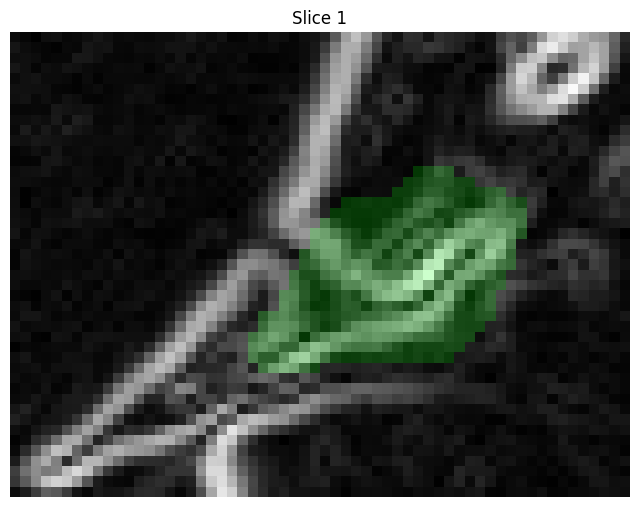

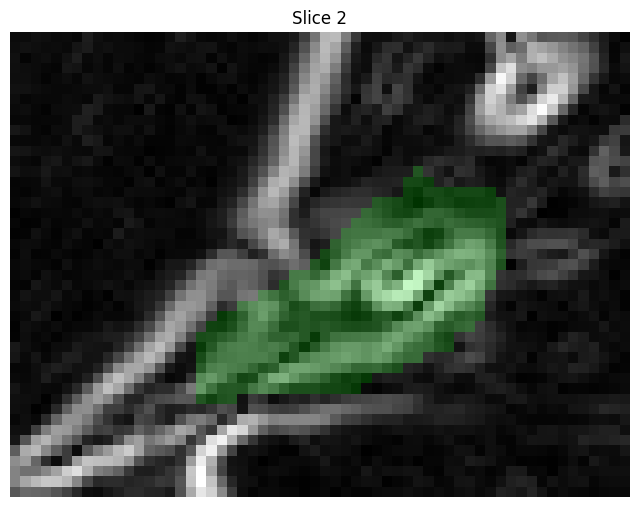

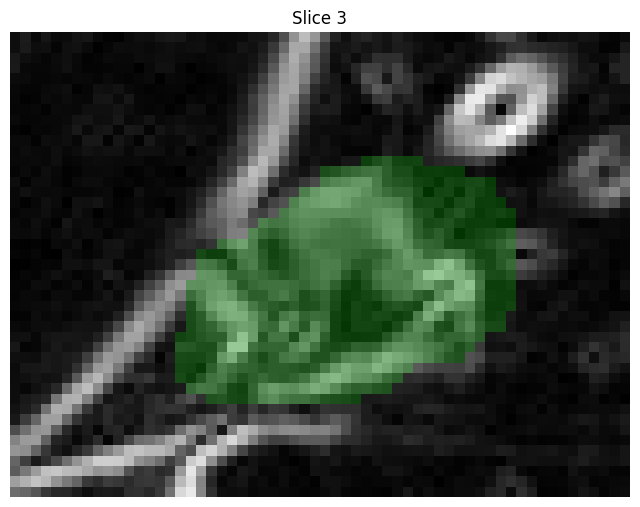

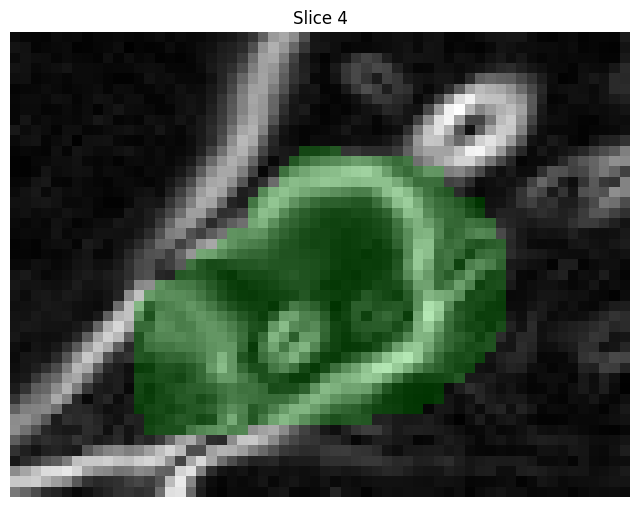

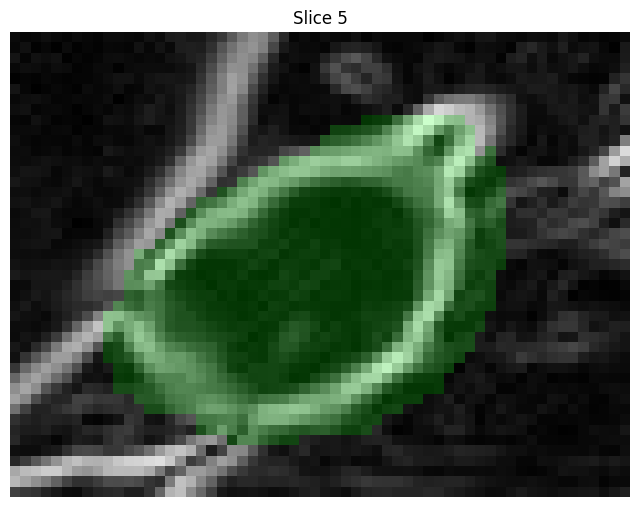

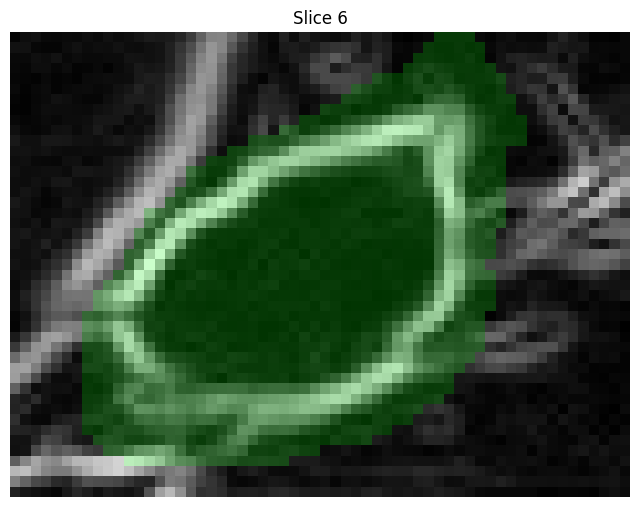

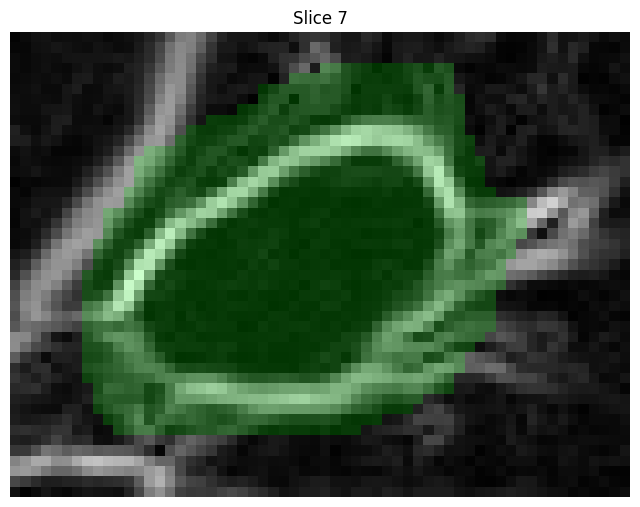

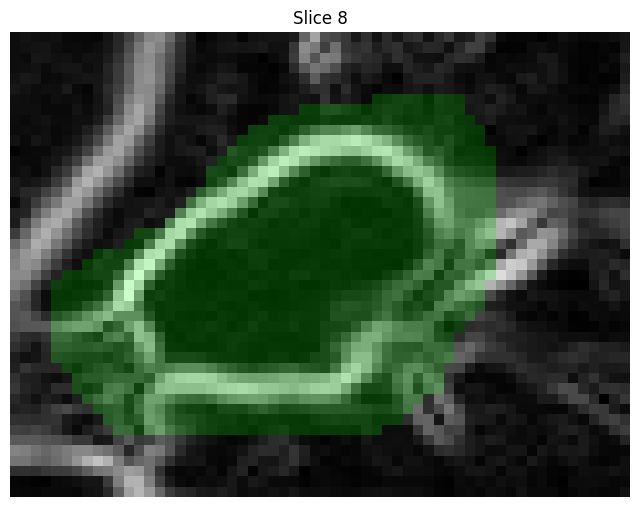

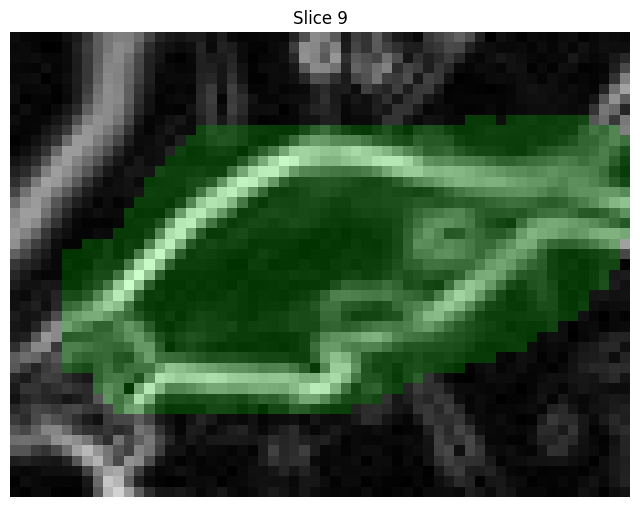

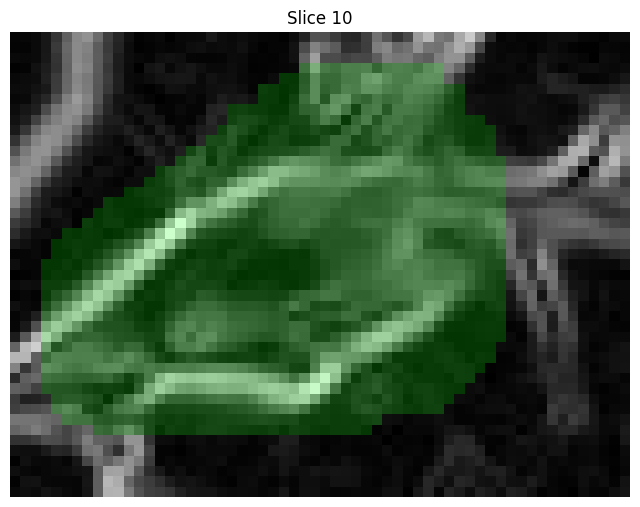

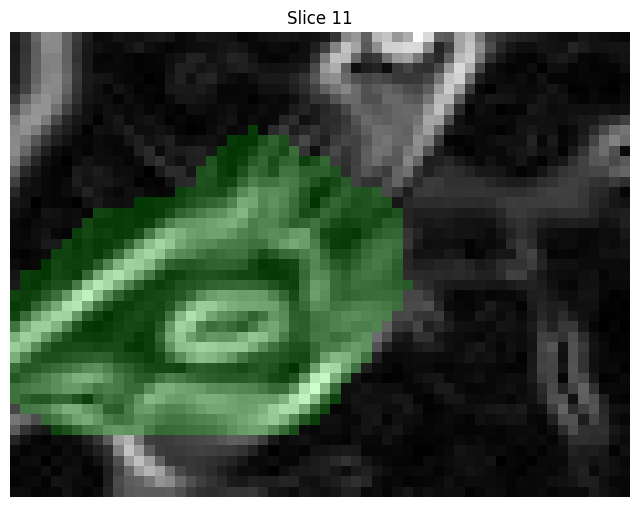

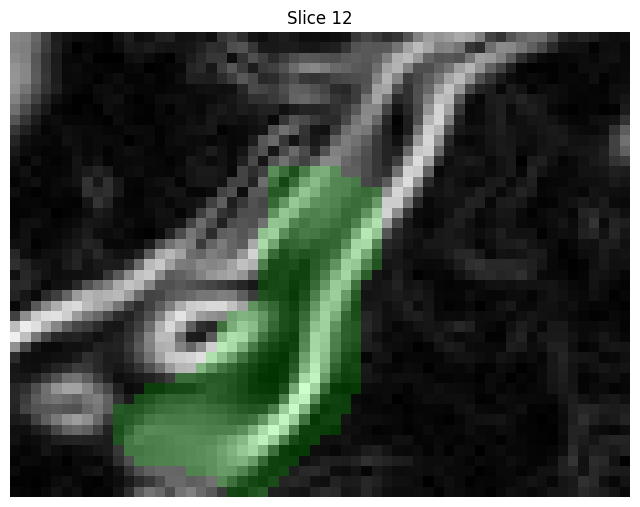

In [11]:
# Visualize slices with segmentation overlay from which radiomics is extracted
visualize_slices_with_segmentation_equal_slices(inputImage_rads, inputMask_rads)

In [12]:
def visualize_slices_with_segmentation(ct_volume, seg_volume):
    # Convert SimpleITK images to NumPy arrays
    ct_array = sitk.GetArrayFromImage(ct_volume)
    seg_array = sitk.GetArrayFromImage(seg_volume)

    # Find slice indices with segmentation
    slice_indices_with_segmentation = find_slices_with_segmentation(seg_volume)

   

    for seg_idx in slice_indices_with_segmentation:
        # Get the physical coordinates of the SEG slice
        seg_spacing = seg_volume.GetSpacing()
        seg_origin = seg_volume.GetOrigin()
        seg_physical_coords = [seg_origin[i] + seg_idx * seg_spacing[i] for i in range(3)]

        # Transform physical coordinates to image indices in CT space
        ct_index_coords = ct_volume.TransformPhysicalPointToIndex(seg_physical_coords)

        # Extract the corresponding CT slice
        ct_slice = ct_array[ct_index_coords[2], :, :]
        seg_slice = seg_array[seg_idx, :, :]
        fig, axes = plt.subplots(1, 1, figsize=(15, 5))
        axes.imshow(ct_slice, cmap='gray')
        axes.imshow(seg_slice, alpha=0.2, cmap='jet', extent=(0, seg_slice.shape[1], seg_slice.shape[0], 0))
        axes.scatter(seg_slice.shape[1] // 2, seg_slice.shape[0] // 2, color='red', marker='x', s=100)
        axes.set_title(f"SEG Slice {seg_idx + 1} (Mapped to CT)")
        axes.axis('off')

        plt.show()
        

In [13]:
def find_slices_with_segmentation(seg_volume):
    # Convert SimpleITK image to NumPy array
    seg_array = sitk.GetArrayFromImage(seg_volume)

    # Find the indices of slices where segmentation is present
    slice_indices = np.any(seg_array != 0, axis=(1, 2))
    
    # Get the slice numbers where segmentation is present
    return np.where(slice_indices)[0]

slice_indices_with_seg = find_slices_with_segmentation(img_mask)
print(slice_indices_with_seg)

[ 0 21 22 23 24 25 26 27 28 29 30 31 32 58]


In [14]:
# Load the flipped CT and segmentation volumes that are going to be given to pyradiomics

ct_img_volume = img_CT_flipped
mask_img_volume = img_mask


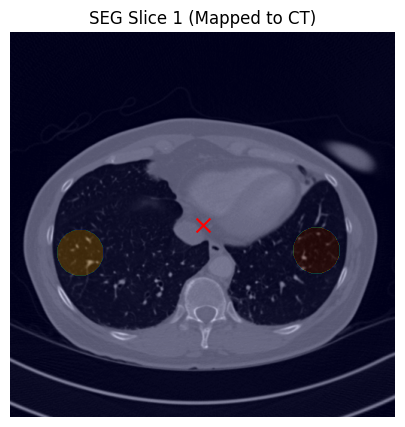

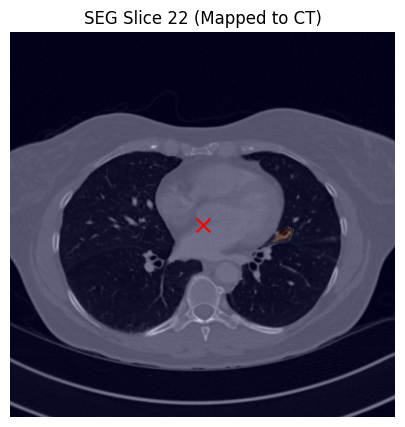

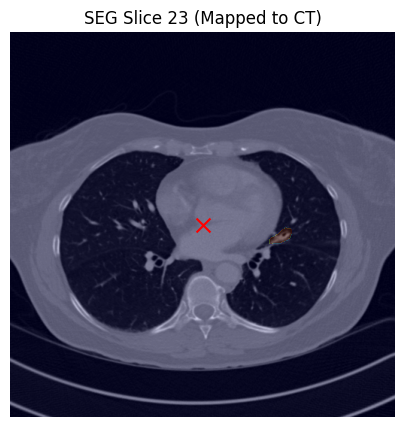

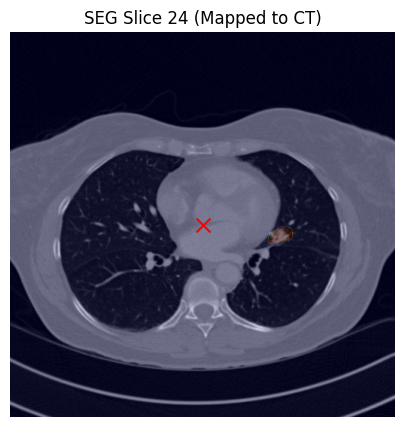

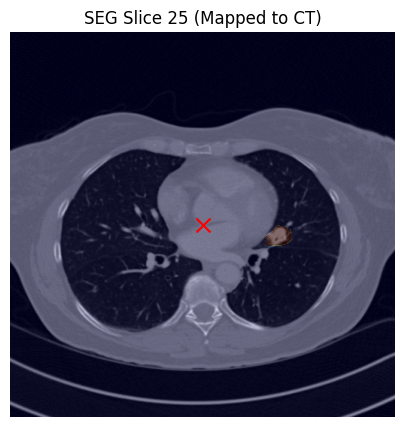

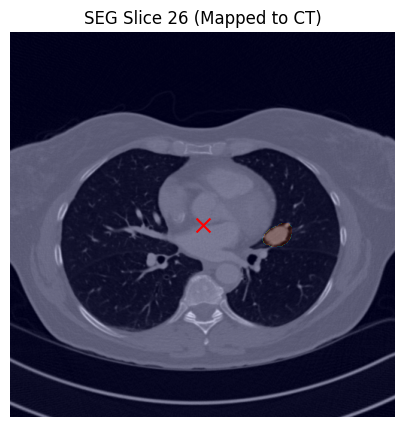

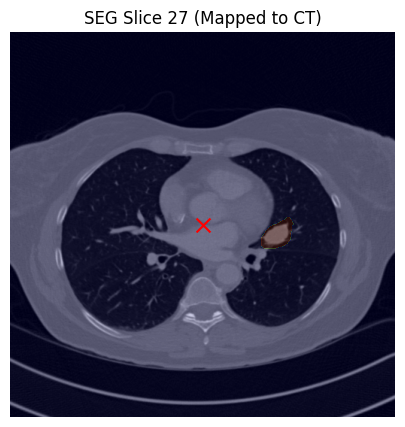

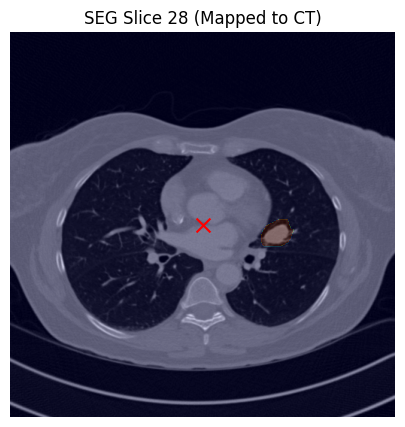

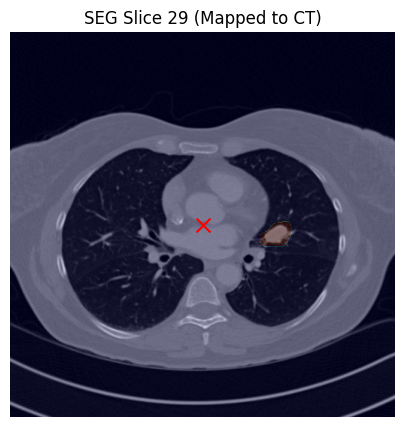

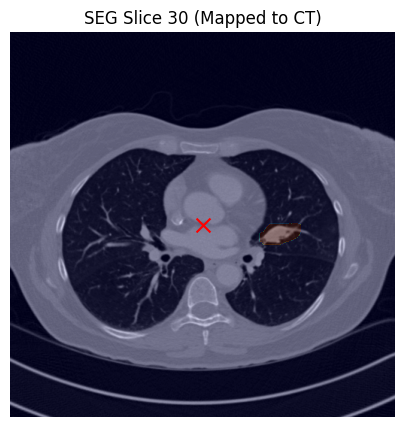

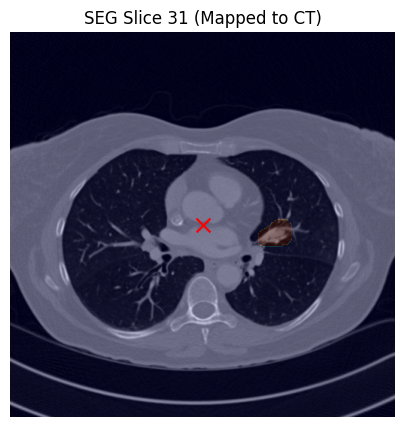

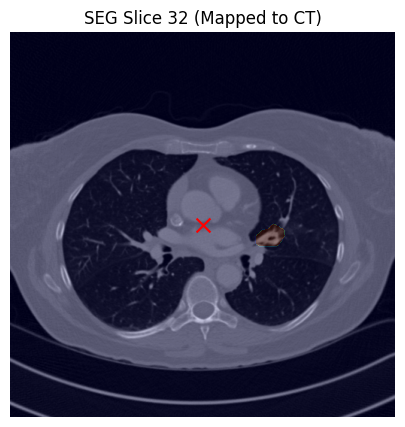

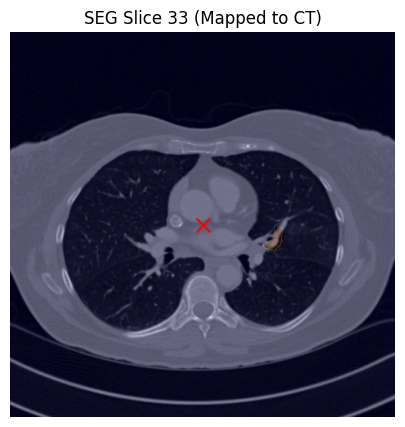

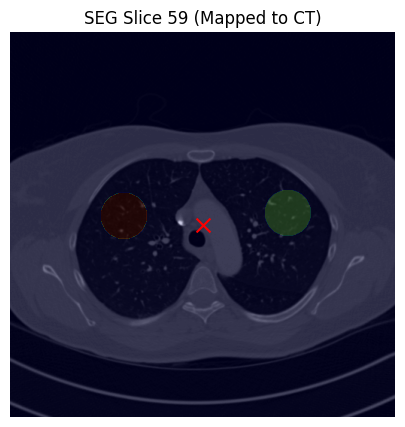

In [15]:
# Visualize slices with segmentation overlay that is going to be given to pyradiomics
visualize_slices_with_segmentation(ct_img_volume, mask_img_volume)
